In [180]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [181]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [182]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [183]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [184]:
tf.keras.backend.clear_session()

In [185]:
subject = 'São Paulo - Consumo de Cimento (t)'
start_index = 0
split_index = 191 #Referente aos 230 anos de input 
window_size = 36
train_split = split_index + 1 - 30

In [186]:
data = pd.read_csv('2003_mo_model_input_SP.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,São Paulo- custo m2 (R$),São Paulo - IDH Longevidade,São Paulo - IDH Renda,São Paulo - Consumo de Cimento (t),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),São Paulo - Produção de Cimento (t),São Paulo - IDH Educacao,São Paulo - Depósito Poupança (R$),São Paulo - value,São Paulo - PIB - Estadual,São Paulo - PIB - Construção Civil,São Paulo - PIB - Per Capita,São Paulo - PIB - Preços de Mercado,São Paulo - Desemprego,São Paulo - IDH,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,12606.426400,0.835043,0.825444,782.111,1.249379,836.486933,1254.225718,13.470493,11.219632,87.918957,1.587388,437.972720,0.794676,8.652299e+07,0.314974,1.034903e+09,4.730940e+07,23.895559,9.819129e+08,8.310335,0.812723,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,12718.304862,0.835425,0.825117,789.891,1.114976,836.981236,1268.256958,13.555238,10.140963,82.539126,1.957841,434.363720,0.794957,8.659168e+07,0.317328,1.036092e+09,4.732994e+07,23.901472,9.822666e+08,8.304194,0.812838,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,12824.573380,0.835806,0.824790,774.309,0.946194,837.344257,1270.950707,13.460122,9.537375,80.042714,2.068918,433.350868,0.795239,8.666036e+07,0.319840,1.037280e+09,4.735047e+07,23.907385,9.826203e+08,8.298053,0.812953,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,12924.495880,0.836188,0.824463,782.071,0.857395,837.859987,1261.707476,13.181964,8.663709,77.171627,2.177406,431.825332,0.795521,8.672905e+07,0.322104,1.038469e+09,4.737101e+07,23.913298,9.829741e+08,8.291912,0.813068,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,13031.542087,0.836570,0.824137,841.400,0.688185,838.094744,1264.729439,12.670356,7.872689,75.721222,2.092594,433.287298,0.795802,8.679773e+07,0.324320,1.039658e+09,4.739155e+07,23.919210,9.833278e+08,8.285771,0.813183,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,39560.290067,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,39516.207562,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,39457.198332,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,39382.246174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


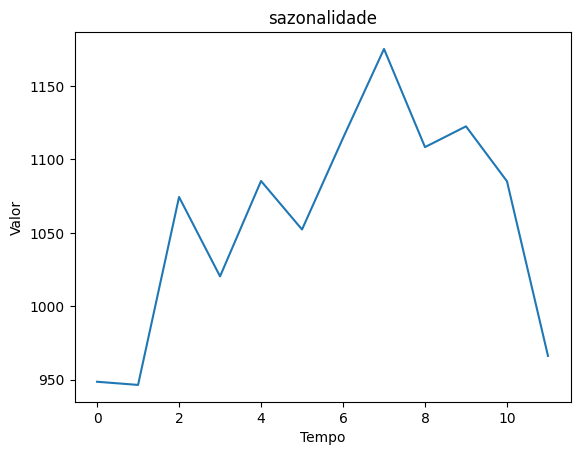

,sazonalidade
sazonalidade,
0,948.563205
1,946.405094
2,1074.415372
3,1020.345809
4,1085.308859
5,1052.289874
6,1114.584668
7,1175.275144
8,1108.395531


In [187]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [188]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,São Paulo- custo m2 (R$),São Paulo - IDH Longevidade,São Paulo - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),São Paulo - Produção de Cimento (t),São Paulo - IDH Educacao,São Paulo - Depósito Poupança (R$),São Paulo - value,São Paulo - PIB - Estadual,São Paulo - PIB - Construção Civil,São Paulo - PIB - Per Capita,São Paulo - PIB - Preços de Mercado,São Paulo - Desemprego,São Paulo - IDH,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,São Paulo - Consumo de Cimento (t)
0,2003-1,12606.426400,0.835043,0.825444,1.249379,836.486933,1254.225718,13.470493,11.219632,87.918957,1.587388,437.972720,0.794676,8.652299e+07,0.314974,1.034903e+09,4.730940e+07,23.895559,9.819129e+08,8.310335,0.812723,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,948.563205,782.111
1,2003-2,12718.304862,0.835425,0.825117,1.114976,836.981236,1268.256958,13.555238,10.140963,82.539126,1.957841,434.363720,0.794957,8.659168e+07,0.317328,1.036092e+09,4.732994e+07,23.901472,9.822666e+08,8.304194,0.812838,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,946.405094,789.891
2,2003-3,12824.573380,0.835806,0.824790,0.946194,837.344257,1270.950707,13.460122,9.537375,80.042714,2.068918,433.350868,0.795239,8.666036e+07,0.319840,1.037280e+09,4.735047e+07,23.907385,9.826203e+08,8.298053,0.812953,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,1074.415372,774.309
3,2003-4,12924.495880,0.836188,0.824463,0.857395,837.859987,1261.707476,13.181964,8.663709,77.171627,2.177406,431.825332,0.795521,8.672905e+07,0.322104,1.038469e+09,4.737101e+07,23.913298,9.829741e+08,8.291912,0.813068,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,1020.345809,782.071
4,2003-5,13031.542087,0.836570,0.824137,0.688185,838.094744,1264.729439,12.670356,7.872689,75.721222,2.092594,433.287298,0.795802,8.679773e+07,0.324320,1.039658e+09,4.739155e+07,23.919210,9.833278e+08,8.285771,0.813183,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,1085.308859,841.400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,39560.290067,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1085.308859,NaN
245,2023-6,39516.207562,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1052.289874,NaN
246,2023-7,39457.198332,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1114.584668,NaN
247,2023-8,39382.246174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1175.275144,NaN


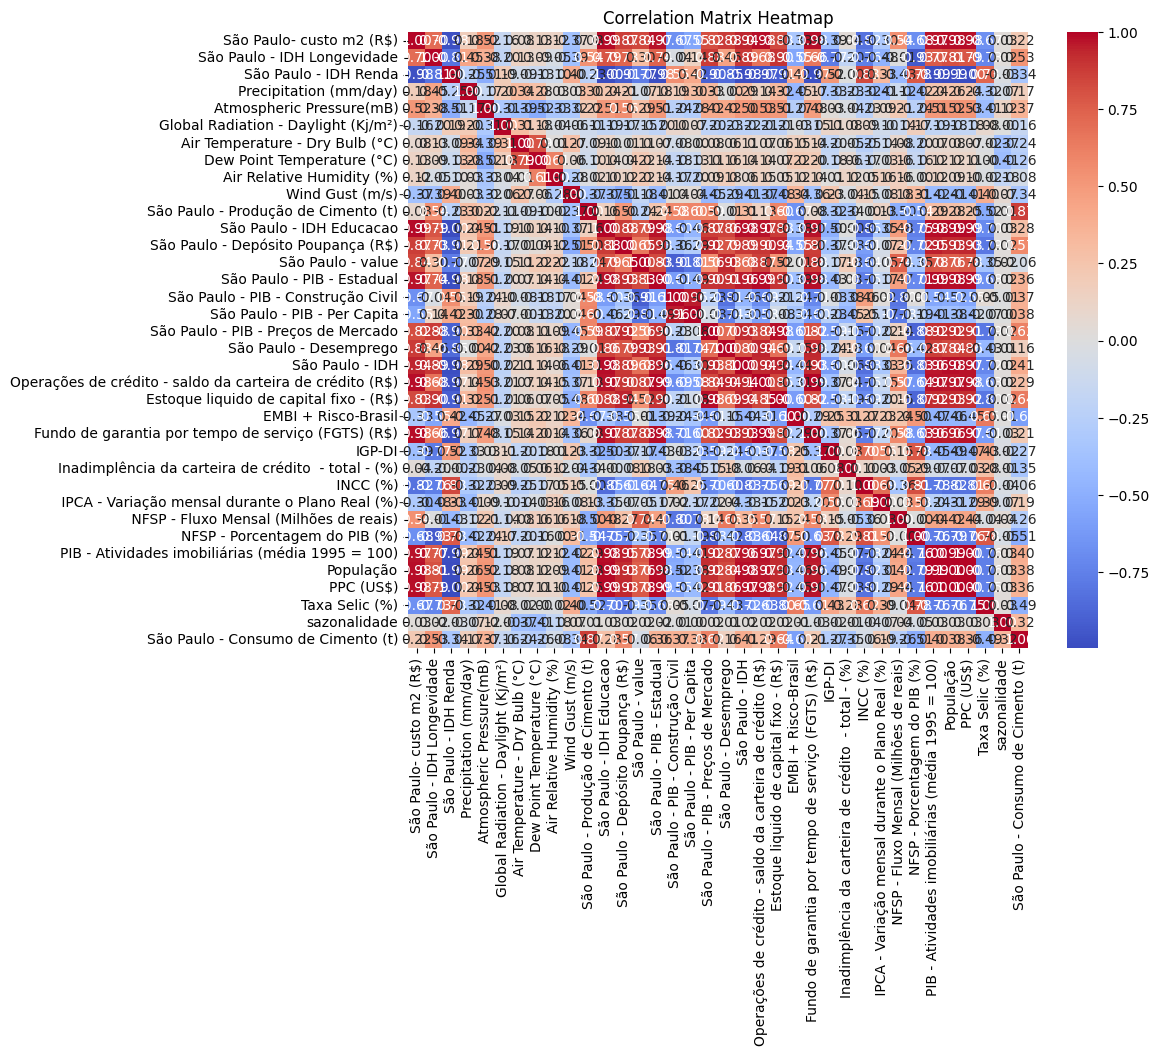

In [189]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [190]:
# data =data.drop(['Precipitation (mm/day)',
#                  'Global Radiation - Daylight (Kj/m²)',
#                  'Air Temperature - Dry Bulb (°C)',
#                  'Dew Point Temperature (°C)', 
#                  'Air Relative Humidity (%)'], axis=1)
# data

In [191]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,São Paulo- custo m2 (R$),São Paulo - IDH Longevidade,São Paulo - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),São Paulo - Produção de Cimento (t),São Paulo - IDH Educacao,São Paulo - Depósito Poupança (R$),São Paulo - value,São Paulo - PIB - Estadual,São Paulo - PIB - Construção Civil,São Paulo - PIB - Per Capita,São Paulo - PIB - Preços de Mercado,São Paulo - Desemprego,São Paulo - IDH,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,-1.578650,-3.010633,1.975626,-0.301613,0.142566,0.520812,-1.329817,-0.236109,1.252113,-0.124646,-1.410736,-1.905888,-1.507482,-1.192538,-1.718526,-0.426010,-1.485366,-2.737181,-0.804344,-2.274413,-1.361787,-2.389042,-0.582420,-1.347324,3.890153,1.258423,3.122582,2.723741,0.364808,4.398348,-1.873379,-2.042341,-1.825286,2.132459,-1.555266
1,-1.555514,-2.936064,1.949013,-0.761612,0.509729,0.633328,-1.262916,-0.875121,0.210080,0.474696,-1.440931,-1.880961,-1.504805,-1.124056,-1.699080,-0.401643,-1.421647,-2.673768,-0.808200,-2.236038,-1.361224,-2.352139,-0.799075,-1.380245,3.551840,1.252755,2.970356,2.350880,0.368956,4.222509,-1.868164,-2.014760,-1.813648,1.592202,-1.585857
2,-1.533538,-2.861496,1.922400,-1.339278,0.779377,0.654929,-1.338004,-1.232691,-0.273456,0.654403,-1.449405,-1.856034,-1.502129,-1.050974,-1.679635,-0.377275,-1.357928,-2.610355,-0.812056,-2.197662,-1.361187,-2.315236,-0.618584,-1.392954,3.391423,1.251338,2.869895,2.123016,0.331110,4.026019,-1.862949,-1.987179,-1.801637,2.999926,0.228678
3,-1.512875,-2.786927,1.895787,-1.643200,1.162456,0.580808,-1.557594,-1.750257,-0.829564,0.829923,-1.462169,-1.831107,-1.499452,-0.985091,-1.660189,-0.352908,-1.294210,-2.546942,-0.815911,-2.159286,-1.360756,-2.278333,-0.139520,-1.396056,3.135979,1.249134,2.773628,2.021477,0.244570,3.811492,-1.857734,-1.959598,-1.789347,1.273293,-0.537754
4,-1.490738,-2.712359,1.869173,-2.222331,1.336831,0.605041,-1.961480,-2.218863,-1.110497,0.692708,-1.449937,-1.806179,-1.496775,-0.920633,-1.640744,-0.328540,-1.230491,-2.483529,-0.819767,-2.120910,-1.359394,-2.241431,0.494336,-1.388786,2.955412,1.238186,2.977624,1.887113,0.279013,3.567576,-1.851305,-1.932017,-1.777381,2.045407,0.383092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1.731820,-0.032597,-1.293826,-0.148786,0.477721,0.222807,-0.800358,-0.294274,0.653520,0.686271,-1.209684,1.419465,0.958836,1.711139,1.107674,-1.587758,-1.453963,0.436685,1.040670,0.784878,1.316363,0.389193,-0.244459,1.237409,0.589021,-0.685819,-1.749976,-2.010387,2.953658,-0.572934,1.406756,1.365911,1.413217,-1.311366,1.658356
188,1.751053,-0.094017,-1.291312,0.576252,0.081167,0.386918,-0.141275,0.308974,0.815453,1.459488,-1.192369,1.421533,0.964677,1.711746,1.098119,-1.580975,-1.459558,0.423023,1.034370,0.748669,1.330590,0.370392,-0.199028,1.214214,1.043728,-0.770458,-1.593005,-1.870713,3.351323,-0.588777,1.428132,1.376610,1.425045,-1.417143,0.710343
189,1.771984,-0.155437,-1.288797,0.719922,0.115490,0.449941,0.514550,0.911081,0.992111,2.084401,-1.178463,1.423601,0.970519,1.717654,1.088565,-1.574192,-1.465154,0.409361,1.028069,0.712461,1.352241,0.351592,-0.173807,1.409043,1.387010,-0.910077,-1.351489,-1.806230,3.404908,-0.612606,1.449507,1.387308,1.436067,-1.597784,0.910742
190,1.795426,-0.216857,-1.286282,1.456172,0.025600,0.495655,0.960594,1.255847,1.020419,2.228054,-1.166182,1.425669,0.976360,1.729082,1.079010,-1.567409,-1.470749,0.395699,1

In [192]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-12)
target_data

0      706.731
1      697.361
2      859.304
3      762.222
4      763.920
        ...   
244        NaN
245        NaN
246        NaN
247        NaN
248        NaN
Name: São Paulo - Consumo de Cimento (t), Length: 249, dtype: float64

In [193]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,São Paulo- custo m2 (R$),São Paulo - IDH Longevidade,São Paulo - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),São Paulo - Produção de Cimento (t),São Paulo - IDH Educacao,São Paulo - Depósito Poupança (R$),São Paulo - value,São Paulo - PIB - Estadual,São Paulo - PIB - Construção Civil,São Paulo - PIB - Per Capita,São Paulo - PIB - Preços de Mercado,São Paulo - Desemprego,São Paulo - IDH,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,-1.578650,-3.010633,1.975626,-0.301613,0.142566,0.520812,-1.329817,-0.236109,1.252113,-0.124646,-1.410736,-1.905888,-1.507482,-1.192538,-1.718526,-0.426010,-1.485366,-2.737181,-0.804344,-2.274413,-1.361787,-2.389042,-0.582420,-1.347324,3.890153,1.258423,3.122582,2.723741,0.364808,4.398348,-1.873379,-2.042341,-1.825286,2.132459,-1.555266
1,-1.555514,-2.936064,1.949013,-0.761612,0.509729,0.633328,-1.262916,-0.875121,0.210080,0.474696,-1.440931,-1.880961,-1.504805,-1.124056,-1.699080,-0.401643,-1.421647,-2.673768,-0.808200,-2.236038,-1.361224,-2.352139,-0.799075,-1.380245,3.551840,1.252755,2.970356,2.350880,0.368956,4.222509,-1.868164,-2.014760,-1.813648,1.592202,-1.585857
2,-1.533538,-2.861496,1.922400,-1.339278,0.779377,0.654929,-1.338004,-1.232691,-0.273456,0.654403,-1.449405,-1.856034,-1.502129,-1.050974,-1.679635,-0.377275,-1.357928,-2.610355,-0.812056,-2.197662,-1.361187,-2.315236,-0.618584,-1.392954,3.391423,1.251338,2.869895,2.123016,0.331110,4.026019,-1.862949,-1.987179,-1.801637,2.999926,0.228678
3,-1.512875,-2.786927,1.895787,-1.643200,1.162456,0.580808,-1.557594,-1.750257,-0.829564,0.829923,-1.462169,-1.831107,-1.499452,-0.985091,-1.660189,-0.352908,-1.294210,-2.546942,-0.815911,-2.159286,-1.360756,-2.278333,-0.139520,-1.396056,3.135979,1.249134,2.773628,2.021477,0.244570,3.811492,-1.857734,-1.959598,-1.789347,1.273293,-0.537754
4,-1.490738,-2.712359,1.869173,-2.222331,1.336831,0.605041,-1.961480,-2.218863,-1.110497,0.692708,-1.449937,-1.806179,-1.496775,-0.920633,-1.640744,-0.328540,-1.230491,-2.483529,-0.819767,-2.120910,-1.359394,-2.241431,0.494336,-1.388786,2.955412,1.238186,2.977624,1.887113,0.279013,3.567576,-1.851305,-1.932017,-1.777381,2.045407,0.383092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,1.128592,1.431225,-1.318515,0.722011,0.549267,-1.026718,1.176687,1.840143,0.978487,0.236066,-0.608419,1.396778,0.396180,1.023937,1.193677,-1.393041,-1.206846,0.733610,1.413038,1.566441,1.335787,0.819304,0.961603,1.338424,-1.233012,0.749349,-0.883659,-0.214006,1.216560,-0.607704,0.952667,1.031384,1.044043,0.043807,-1.585857
158,1.151469,1.391258,-1.316685,0.664991,0.839118,-1.956534,0.268656,1.168034,0.918648,0.025668,-0.653197,1.393445,0.418789,1.033712,1.195577,-1.411276,-1.217300,0.727991,1.392752,1.539489,1.325546,0.808136,1.030624,1.300351,-1.299304,0.977327,-0.950771,-0.434717,1.155373,-0.620523,0.954843,1.042716,1.056960,0.210856,0.228678
159,1.174175,1.351290,-1.314854,-0.285297,1.070539,-2.767601,-0.480031,0.270107,0.436162,-0.140782,-0.699576,1.390112,0.441398,1.049101,1.197477,-1.429511,-1.227755,0.722372,1.372465,1.512536,1.315396,0.796969,1.039183,1.250508,-1.248662,1.048267,-1.028465,-0.524091,1.056140,-0.631530,0.957019,1.054049,1.070172,0.107070,-0.537754
160,1.198876,1.311322,-1.313024,-0.404072,1.228328,-3.374033,-1.207982,-0.416655,0.239526,-0.235046,-0.757794,1.386779,0.464007,1.059564,1.199378,-1.447746,-1.238210,0.716753,1.

In [194]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      706.731
1      697.361
2      859.304
3      762.222
4      763.920
        ...   
157    757.915
158    923.634
159    756.663
160    872.715
161    844.988
Name: São Paulo - Consumo de Cimento (t), Length: 162, dtype: float64

In [195]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [196]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(126, 36, 35)

In [197]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,São Paulo- custo m2 (R$),São Paulo - IDH Longevidade,São Paulo - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),São Paulo - Produção de Cimento (t),São Paulo - IDH Educacao,São Paulo - Depósito Poupança (R$),São Paulo - value,São Paulo - PIB - Estadual,São Paulo - PIB - Construção Civil,São Paulo - PIB - Per Capita,São Paulo - PIB - Preços de Mercado,São Paulo - Desemprego,São Paulo - IDH,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
126,0.458283,0.352975,-0.675018,-0.896568,0.887074,-0.739530,-1.479166,-1.113982,0.096529,-0.838235,1.357021,0.506668,1.415527,0.718372,0.835331,-0.070173,-0.126212,1.060884,0.965416,0.617332,0.722924,0.944085,-0.882533,0.551812,-0.368821,-0.155884,0.045243,0.888984,-0.230612,-0.460555,0.913820,0.651397,0.697312,-1.048761,0.798074
127,0.478617,0.331182,-0.669105,-0.910642,0.540011,-0.066876,-1.041023,-0.841739,0.003591,-0.864011,1.320237,0.519610,1.424692,0.803494,0.853864,-0.120590,-0.162580,1.058281,0.995407,0.624883,0.745258,0.947319,-0.815413,0.566622,-0.328087,-0.349984,0.061828,0.954254,-0.156322,-0.440372,0.923198,0.664707,0.706933,-0.649312,1.658356
128,0.498554,0.309390,-0.663192,-0.165312,-0.008751,0.207007,-0.442627,-0.238470,0.234334,-0.879773,1.259517,0.532552,1.433858,0.892135,0.872396,-0.171007,-0.198948,1.055678,1.025397,0.632435,0.767990,0.950553,-0.745839,0.568617,-0.176031,-0.529294,0.046225,1.045217,-0.120008,-0.419247,0.932576,0.678017,0.715675,-0.535369,0.710343
129,0.518579,0.287598,-0.657279,0.385882,-0.195358,0.738971,0.207765,0.232682,0.216737,-0.890673,1.196227,0.545494,1.443023,0.945408,0.890929,-0.221425,-0.235316,1.053074,1.055388,0.639987,0.799035,0.953786,-0.687348,0.719776,-0.113037,-0.788101,0.032522,1.176395,-0.143194,-0.397019,0.941953,0.691327,0.723490,-1.288807,0.910742
130,0.538674,0.265805,-0.651366,0.676604,-0.325096,1.034178,0.878743,0.589739,0.006376,-0.898164,1.135312,0.558436,1.452189,0.989786,0.909462,-0.271842,-0.271684,1.050471,1.085379,0.647538,0.830824,0.957020,-0.639220,0.905478,-0.022703,-1.020394,0.042757,1.303259,-0.028712,-0.376532,0.942711,0.704637,0.730579,-1.507550,0.380306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1.731820,-0.032597,-1.293826,-0.148786,0.477721,0.222807,-0.800358,-0.294274,0.653520,0.686271,-1.209684,1.419465,0.958836,1.711139,1.107674,-1.587758,-1.453963,0.436685,1.040670,0.784878,1.316363,0.389193,-0.244459,1.237409,0.589021,-0.685819,-1.749976,-2.010387,2.953658,-0.572934,1.406756,1.365911,1.413217,-1.311366,1.658356
188,1.751053,-0.094017,-1.291312,0.576252,0.081167,0.386918,-0.141275,0.308974,0.815453,1.459488,-1.192369,1.421533,0.964677,1.711746,1.098119,-1.580975,-1.459558,0.423023,1.034370,0.748669,1.330590,0.370392,-0.199028,1.214214,1.043728,-0.770458,-1.593005,-1.870713,3.351323,-0.588777,1.428132,1.376610,1.425045,-1.417143,0.710343
189,1.771984,-0.155437,-1.288797,0.719922,0.115490,0.449941,0.514550,0.911081,0.992111,2.084401,-1.178463,1.423601,0.970519,1.717654,1.088565,-1.574192,-1.465154,0.409361,1.028069,0.712461,1.352241,0.351592,-0.173807,1.409043,1.387010,-0.910077,-1.351489,-1.806230,3.404908,-0.612606,1.449507,1.387308,1.436067,-1.597784,0.910742
190,1.795426,-0.216857,-1.286282,1.456172,0.025600,0.495655,0.960594,1.255847,1.020419,2.228054,-1.166182,1.425669,0.976360,1.729082,1.079010,-1.567409,-1.470749,0.395699,1.021769,0.676253,1.370978,0.332791,-0.1698

In [198]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(30, 36, 35)

In [199]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [200]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    train, train_val = validation_splitter(train_input, 6)
    target,target_val = validation_splitter(train_target, 6)
#     display(train.shape)
#     display(train_val.shape)
#     display(target.shape)
#     display(target_val.shape)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                             return_sequences=True, 
                             input_shape=(reshaped_train.shape[1],
                                          reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(180,activation='tanh'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer, loss='mean_squared_error')   
    history = model.fit(train, 
                        target, 
                        epochs=10000,
                        validation_data=(train_val,
                                         target_val),
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [201]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(50)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [202]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[1726279152, 999855517, 2536489306, 430087492, 573781395, 1802794782, 2563937591, 58008540, 1047682049, 3114132969, 4169339040, 1644480577, 2795789990, 2710349019, 2874698793, 186450272, 643951221, 3010305758, 2072201389, 835325382, 1990311326, 61750814, 2963458097, 1184830849, 180092670, 922372885, 578383711, 4197412715, 2883013086, 3163619321, 3375359590, 4076047301, 2432545679, 2828456051, 1578268681, 1267195718, 3582389216, 79244505, 3701967409, 3396118467, 979746394, 4016461585, 61750386, 3062630176, 2659550392, 3828448005, 3143399594, 1014554831, 724113497, 2673733710]


Step: 0 ___________________________________________
val_loss: 14148.9033203125
winner_seed: 1726279152


Step: 1 ___________________________________________
val_loss: 8973.42578125
winner_seed: 999855517


Step: 2 ___________________________________________
val_loss: 18738.755859375


Step: 3 ___________________________________________
val_loss: 17832.517578125


Step: 4 __________________________________________

In [203]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)

Epoch 1/10000
4/4 [==============================] - 3s 125ms/step - loss: 987575.9375 - val_loss: 22616.5215
Epoch 2/10000
4/4 [==============================] - 0s 9ms/step - loss: 26790.4160 - val_loss: 19172.7715
Epoch 3/10000
4/4 [==============================] - 0s 9ms/step - loss: 27039.9590 - val_loss: 24613.6699
Epoch 4/10000
4/4 [==============================] - 0s 9ms/step - loss: 26668.0195 - val_loss: 23835.4375
Epoch 5/10000
4/4 [==============================] - 0s 9ms/step - loss: 26572.4238 - val_loss: 21869.9434
Epoch 6/10000
4/4 [==============================] - 0s 9ms/step - loss: 30838.8086 - val_loss: 21851.5566
Epoch 7/10000
4/4 [==============================] - 0s 10ms/step - loss: 26845.8086 - val_loss: 28572.8398
Epoch 8/10000
4/4 [==============================] - 0s 10ms/step - loss: 26579.6426 - val_loss: 25901.3633
Epoch 9/10000
4/4 [==============================] - 0s 10ms/step - loss: 26687.6660 - val_loss: 25054.4043
Epoch 10/10000
4/4 [===========

4/4 [==============================] - 0s 10ms/step - loss: 28835.0312 - val_loss: 26456.4473
Epoch 77/10000
4/4 [==============================] - 0s 12ms/step - loss: 24826.0332 - val_loss: 19384.0234
Epoch 78/10000
4/4 [==============================] - 0s 10ms/step - loss: 24222.0098 - val_loss: 19073.7559
Epoch 79/10000
4/4 [==============================] - 0s 10ms/step - loss: 26646.7969 - val_loss: 34351.3516
Epoch 80/10000
4/4 [==============================] - 0s 9ms/step - loss: 28943.6875 - val_loss: 18814.2012
Epoch 81/10000
4/4 [==============================] - 0s 9ms/step - loss: 27878.6523 - val_loss: 23692.7168
Epoch 82/10000
4/4 [==============================] - 0s 9ms/step - loss: 27068.2246 - val_loss: 22340.6328
Epoch 83/10000
4/4 [==============================] - 0s 8ms/step - loss: 24225.8594 - val_loss: 18358.1543
Epoch 84/10000
4/4 [==============================] - 0s 9ms/step - loss: 24649.1953 - val_loss: 26324.5664
Epoch 85/10000
4/4 [===================

4/4 [==============================] - 0s 8ms/step - loss: 26165.3770 - val_loss: 20376.7285
Epoch 152/10000
4/4 [==============================] - 0s 9ms/step - loss: 24466.7168 - val_loss: 36095.7969
Epoch 153/10000
4/4 [==============================] - 0s 8ms/step - loss: 25144.8066 - val_loss: 22880.0215
Epoch 154/10000
4/4 [==============================] - 0s 9ms/step - loss: 24231.6445 - val_loss: 16478.6777
Epoch 155/10000
4/4 [==============================] - 0s 10ms/step - loss: 23164.8828 - val_loss: 22892.0078
Epoch 156/10000
4/4 [==============================] - 0s 10ms/step - loss: 22593.1230 - val_loss: 31780.2207
Epoch 157/10000
4/4 [==============================] - 0s 10ms/step - loss: 23751.3047 - val_loss: 16217.4033
Epoch 158/10000
4/4 [==============================] - 0s 10ms/step - loss: 22028.2754 - val_loss: 23251.1035
Epoch 159/10000
4/4 [==============================] - 0s 10ms/step - loss: 22538.4688 - val_loss: 14571.2236
Epoch 160/10000
4/4 [=========

Epoch 226/10000
4/4 [==============================] - 0s 10ms/step - loss: 21026.5586 - val_loss: 17876.1758
Epoch 227/10000
4/4 [==============================] - 0s 9ms/step - loss: 16812.0508 - val_loss: 19309.8613
Epoch 228/10000
4/4 [==============================] - 0s 9ms/step - loss: 22093.2793 - val_loss: 19452.3027
Epoch 229/10000
4/4 [==============================] - 0s 9ms/step - loss: 18345.3203 - val_loss: 16940.1094
Epoch 230/10000
4/4 [==============================] - 0s 9ms/step - loss: 25188.5391 - val_loss: 16238.0312
Epoch 231/10000
4/4 [==============================] - 0s 9ms/step - loss: 24444.6055 - val_loss: 18012.4336
Epoch 232/10000
4/4 [==============================] - 0s 10ms/step - loss: 23116.8477 - val_loss: 21405.0469
Epoch 233/10000
4/4 [==============================] - 0s 10ms/step - loss: 24599.2910 - val_loss: 22246.8945
Epoch 234/10000
4/4 [==============================] - 0s 10ms/step - loss: 25468.3926 - val_loss: 21788.9023
Epoch 235/10000

Epoch 301/10000
4/4 [==============================] - 0s 11ms/step - loss: 19589.7812 - val_loss: 13069.1445
Epoch 302/10000
4/4 [==============================] - 0s 10ms/step - loss: 17346.6172 - val_loss: 12515.6201
Epoch 303/10000
4/4 [==============================] - 0s 9ms/step - loss: 20296.9570 - val_loss: 11262.0107
Epoch 304/10000
4/4 [==============================] - 0s 8ms/step - loss: 13274.3916 - val_loss: 12858.2842
Epoch 305/10000
4/4 [==============================] - 0s 9ms/step - loss: 21248.7031 - val_loss: 14846.7041
Epoch 306/10000
4/4 [==============================] - 0s 9ms/step - loss: 22028.3672 - val_loss: 14605.4746
Epoch 307/10000
4/4 [==============================] - 0s 8ms/step - loss: 19730.8496 - val_loss: 13745.2363
Epoch 308/10000
4/4 [==============================] - 0s 9ms/step - loss: 18209.1484 - val_loss: 14807.3018
Epoch 309/10000
4/4 [==============================] - 0s 10ms/step - loss: 21836.2539 - val_loss: 15358.6025
Epoch 310/10000


Epoch 376/10000
4/4 [==============================] - 0s 10ms/step - loss: 15865.4473 - val_loss: 16650.4355
Epoch 377/10000
4/4 [==============================] - 0s 10ms/step - loss: 15978.8271 - val_loss: 19628.5215
Epoch 378/10000
4/4 [==============================] - 0s 10ms/step - loss: 15176.0664 - val_loss: 17214.2715
Epoch 379/10000
4/4 [==============================] - 0s 11ms/step - loss: 16850.6348 - val_loss: 14304.3555
Epoch 380/10000
4/4 [==============================] - 0s 10ms/step - loss: 14761.9492 - val_loss: 15019.6357
Epoch 381/10000
4/4 [==============================] - 0s 9ms/step - loss: 18130.0957 - val_loss: 17194.8301
Epoch 382/10000
4/4 [==============================] - 0s 8ms/step - loss: 16084.8857 - val_loss: 14508.3242
Epoch 383/10000
4/4 [==============================] - 0s 9ms/step - loss: 17485.8496 - val_loss: 15233.1562
Epoch 384/10000
4/4 [==============================] - 0s 10ms/step - loss: 20738.6426 - val_loss: 12710.1992
Epoch 385/100

Epoch 451/10000
4/4 [==============================] - 0s 9ms/step - loss: 15596.2031 - val_loss: 10968.9268
Epoch 452/10000
4/4 [==============================] - 0s 9ms/step - loss: 17881.7480 - val_loss: 13627.4482
Epoch 453/10000
4/4 [==============================] - 0s 9ms/step - loss: 18345.7324 - val_loss: 13897.7764
Epoch 454/10000
4/4 [==============================] - 0s 10ms/step - loss: 14826.3105 - val_loss: 14444.2500
Epoch 455/10000
4/4 [==============================] - 0s 10ms/step - loss: 17185.2031 - val_loss: 12036.6191
Epoch 456/10000
4/4 [==============================] - 0s 10ms/step - loss: 16632.6895 - val_loss: 12744.1582
Epoch 457/10000
4/4 [==============================] - 0s 10ms/step - loss: 16390.8516 - val_loss: 12997.1016
Epoch 458/10000
4/4 [==============================] - 0s 9ms/step - loss: 18350.8359 - val_loss: 14057.8633
Epoch 459/10000
4/4 [==============================] - 0s 9ms/step - loss: 19422.0996 - val_loss: 16313.5361
Epoch 460/10000

Epoch 526/10000
4/4 [==============================] - 0s 9ms/step - loss: 18136.5293 - val_loss: 9365.4150
Epoch 527/10000
4/4 [==============================] - 0s 8ms/step - loss: 16659.2031 - val_loss: 8765.1582
Epoch 528/10000
4/4 [==============================] - 0s 8ms/step - loss: 16695.6504 - val_loss: 10176.4600
Epoch 529/10000
4/4 [==============================] - 0s 9ms/step - loss: 15883.9824 - val_loss: 9421.9062
Epoch 530/10000
4/4 [==============================] - 0s 9ms/step - loss: 20884.8184 - val_loss: 8196.3477
Epoch 531/10000
4/4 [==============================] - 0s 9ms/step - loss: 16249.9883 - val_loss: 10059.1680
Epoch 532/10000
4/4 [==============================] - 0s 10ms/step - loss: 15224.1504 - val_loss: 9972.0479
Epoch 533/10000
4/4 [==============================] - 0s 10ms/step - loss: 18552.8027 - val_loss: 11312.0674
Epoch 534/10000
4/4 [==============================] - 0s 10ms/step - loss: 16336.0723 - val_loss: 10770.8652
Epoch 535/10000
4/4 [

4/4 [==============================] - 0s 9ms/step - loss: 15702.8594 - val_loss: 9429.8350
Epoch 602/10000
4/4 [==============================] - 0s 9ms/step - loss: 14733.5332 - val_loss: 9001.6104
Epoch 603/10000
4/4 [==============================] - 0s 9ms/step - loss: 13665.2295 - val_loss: 8452.4873
Epoch 604/10000
4/4 [==============================] - 0s 10ms/step - loss: 17128.7461 - val_loss: 8971.8213
Epoch 605/10000
4/4 [==============================] - 0s 10ms/step - loss: 14257.1309 - val_loss: 9004.6494
Epoch 606/10000
4/4 [==============================] - 0s 10ms/step - loss: 17484.8027 - val_loss: 8913.0918
Epoch 607/10000
4/4 [==============================] - 0s 10ms/step - loss: 15666.9805 - val_loss: 9241.2783
Epoch 608/10000
4/4 [==============================] - 0s 10ms/step - loss: 16787.9004 - val_loss: 10840.8008
Epoch 609/10000
4/4 [==============================] - 0s 10ms/step - loss: 16491.4434 - val_loss: 8975.8682
Epoch 610/10000
4/4 [================

4/4 [==============================] - 0s 10ms/step - loss: 18331.1172 - val_loss: 18915.5098
Epoch 677/10000
4/4 [==============================] - 0s 10ms/step - loss: 17777.9668 - val_loss: 17914.7324
Epoch 678/10000
4/4 [==============================] - 0s 10ms/step - loss: 13927.7520 - val_loss: 17860.7285
Epoch 679/10000
4/4 [==============================] - 0s 10ms/step - loss: 14601.3115 - val_loss: 19214.8906
Epoch 680/10000
4/4 [==============================] - 0s 11ms/step - loss: 15707.3789 - val_loss: 19017.7422
Epoch 681/10000
4/4 [==============================] - 0s 10ms/step - loss: 13936.0400 - val_loss: 17057.4023
Epoch 682/10000
4/4 [==============================] - 0s 9ms/step - loss: 17058.8457 - val_loss: 18044.3750
Epoch 683/10000
4/4 [==============================] - 0s 9ms/step - loss: 14655.5977 - val_loss: 19579.7227
Epoch 684/10000
4/4 [==============================] - 0s 9ms/step - loss: 14753.0605 - val_loss: 17027.4961
Epoch 685/10000
4/4 [========

4/4 [==============================] - 0s 10ms/step - loss: 16486.0742 - val_loss: 8415.5225
Epoch 752/10000
4/4 [==============================] - 0s 10ms/step - loss: 15372.5752 - val_loss: 10070.0732
Epoch 753/10000
4/4 [==============================] - 0s 9ms/step - loss: 13917.3047 - val_loss: 10987.5029
Epoch 754/10000
4/4 [==============================] - 0s 9ms/step - loss: 14763.4131 - val_loss: 9704.3184
Epoch 755/10000
4/4 [==============================] - 0s 9ms/step - loss: 17298.3633 - val_loss: 9212.7910
Epoch 756/10000
4/4 [==============================] - 0s 9ms/step - loss: 18291.5449 - val_loss: 10556.3604
Epoch 757/10000
4/4 [==============================] - 0s 9ms/step - loss: 17080.1348 - val_loss: 10206.9355
Epoch 758/10000
4/4 [==============================] - 0s 9ms/step - loss: 16439.6992 - val_loss: 9150.2041
Epoch 759/10000
4/4 [==============================] - 0s 9ms/step - loss: 16980.6113 - val_loss: 9224.0166
Epoch 760/10000
4/4 [=================

4/4 [==============================] - 0s 10ms/step - loss: 14280.5166 - val_loss: 17775.2910
Epoch 827/10000
4/4 [==============================] - 0s 10ms/step - loss: 11763.5811 - val_loss: 16548.4180
Epoch 828/10000
4/4 [==============================] - 0s 10ms/step - loss: 17536.0781 - val_loss: 16647.7363
Epoch 829/10000
4/4 [==============================] - 0s 10ms/step - loss: 18796.6484 - val_loss: 17523.8652
Epoch 830/10000
4/4 [==============================] - 0s 12ms/step - loss: 15796.9385 - val_loss: 15843.8496
Epoch 831/10000
4/4 [==============================] - 0s 10ms/step - loss: 14448.9766 - val_loss: 16753.4766
Epoch 832/10000
4/4 [==============================] - 0s 9ms/step - loss: 13556.8379 - val_loss: 16958.8789
Epoch 833/10000
4/4 [==============================] - 0s 10ms/step - loss: 14746.5811 - val_loss: 16776.8086
Epoch 834/10000
4/4 [==============================] - 0s 9ms/step - loss: 17968.9004 - val_loss: 17826.0176
Epoch 835/10000
4/4 [=======

Epoch 901/10000
4/4 [==============================] - 0s 10ms/step - loss: 13448.7275 - val_loss: 14237.8418
Epoch 902/10000
4/4 [==============================] - 0s 9ms/step - loss: 15392.5664 - val_loss: 15032.8486
Epoch 903/10000
4/4 [==============================] - 0s 9ms/step - loss: 14520.1592 - val_loss: 19211.4141
Epoch 904/10000
4/4 [==============================] - 0s 9ms/step - loss: 11150.0576 - val_loss: 17151.6719
Epoch 905/10000
4/4 [==============================] - 0s 9ms/step - loss: 15209.8428 - val_loss: 17622.0664
Epoch 906/10000
4/4 [==============================] - 0s 9ms/step - loss: 16657.2734 - val_loss: 15025.5674
Epoch 907/10000
4/4 [==============================] - 0s 9ms/step - loss: 20721.6426 - val_loss: 15073.7861
Epoch 908/10000
4/4 [==============================] - 0s 9ms/step - loss: 15923.5537 - val_loss: 16050.3066
Epoch 909/10000
4/4 [==============================] - 0s 10ms/step - loss: 16450.7012 - val_loss: 15699.5205
Epoch 910/10000
4

Epoch 976/10000
4/4 [==============================] - 0s 10ms/step - loss: 17274.7656 - val_loss: 13112.2070
Epoch 977/10000
4/4 [==============================] - 0s 12ms/step - loss: 20757.6660 - val_loss: 12862.2529
Epoch 978/10000
4/4 [==============================] - 0s 10ms/step - loss: 12479.1211 - val_loss: 11370.4160
Epoch 979/10000
4/4 [==============================] - 0s 10ms/step - loss: 13797.3252 - val_loss: 12857.9043
Epoch 980/10000
4/4 [==============================] - 0s 10ms/step - loss: 13183.8750 - val_loss: 10374.6465
Epoch 981/10000
4/4 [==============================] - 0s 10ms/step - loss: 15406.5225 - val_loss: 10479.4941
Epoch 982/10000
4/4 [==============================] - 0s 10ms/step - loss: 17146.4824 - val_loss: 10007.6338
Epoch 983/10000
4/4 [==============================] - 0s 9ms/step - loss: 17135.5312 - val_loss: 13314.0918
Epoch 984/10000
4/4 [==============================] - 0s 9ms/step - loss: 15390.2412 - val_loss: 12286.6016
Epoch 985/10

4/4 [==============================] - 0s 10ms/step - loss: 15972.0762 - val_loss: 13098.5645
Epoch 1051/10000
4/4 [==============================] - 0s 10ms/step - loss: 15349.5664 - val_loss: 12254.0400
Epoch 1052/10000
4/4 [==============================] - 0s 10ms/step - loss: 14541.5850 - val_loss: 12809.2754
Epoch 1053/10000
4/4 [==============================] - 0s 10ms/step - loss: 16632.0039 - val_loss: 14121.8154
Epoch 1054/10000
4/4 [==============================] - 0s 11ms/step - loss: 14763.2588 - val_loss: 15707.4580
Epoch 1055/10000
4/4 [==============================] - 0s 11ms/step - loss: 13787.6250 - val_loss: 14627.8643
Epoch 1056/10000
4/4 [==============================] - 0s 11ms/step - loss: 12927.2158 - val_loss: 13749.8867
Epoch 1057/10000
4/4 [==============================] - 0s 9ms/step - loss: 17524.5957 - val_loss: 11809.4990
Epoch 1058/10000
4/4 [==============================] - 0s 9ms/step - loss: 14169.1191 - val_loss: 12078.5752
Epoch 1059/10000
4/4

In [204]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [205]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 15ms/step


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12,Month-13,Month-14,Month-15,Month-16,Month-17,Month-18,Month-19,Month-20,Month-21,Month-22,Month-23,Month-24,Month-25,Month-26,Month-27,Month-28,Month-29,Month-30
Prediction,890.10437,852.317261,729.378418,967.39917,829.728455,920.466187,895.085327,899.377441,867.187012,828.624268,830.116333,827.893555,825.950928,914.848022,861.29187,892.70459,887.888062,882.25885,836.457275,736.121887,858.271118,895.031372,948.385376,882.170532,793.965759,811.959839,865.02478,814.78479,676.226501,852.162109
Target,910.653,937.696,871.611,795.853,804.767,712.733,763.665,727.397,855.245,855.042,648.867,1003.807,855.104,913.329,849.262,897.883,860.059,771.417,860.232,773.607,790.146,886.929,941.6,817.301,957.289,978.99,906.956,980.948,872.046,692.232
Error,20.548645,85.378723,142.232605,171.546143,24.961426,207.733215,131.420349,171.980469,11.942017,26.417725,181.249329,175.913452,29.153076,1.519043,12.029846,5.178406,27.829041,110.841858,23.774719,37.485107,68.125122,8.102356,6.7854,64.869507,163.323242,167.030151,41.931213,166.163208,195.819519,159.930115


In [206]:
display(mae)
display(mape)

88.040504

0.107499324

In [207]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [208]:
errors, mae, mape = year_mae_mape_calculator(trained_model,
                                             reshaped_test, 
                                             reshaped_test_target,
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 15ms/step
Ano-0: |Prediction[[10337.678]] - Target[9887.336000000001]| =  Error: [[450.3418]]; MAPE:[[0.04554733]]
1/1 [==============================] - 0s 15ms/step
Ano-0: |Prediction[[10421.381]] - Target[10216.868999999999]| =  Error: [[204.51172]]; MAPE:[[0.02001706]]
1/1 [==============================] - 0s 16ms/step
Ano-5: |Prediction[[4814.1235]] - Target[5388.461]| =  Error: [[574.3374]]; MAPE:[[0.10658654]]


[array([[450.3418]], dtype=float32),
 array([[204.51172]], dtype=float32),
 array([[574.3374]], dtype=float32)]

409.73032

0.057383645